In [2]:
import os


In [10]:
os.path.join("./output/", "lego","")

'./output/lego/'

In [1]:
import numpy as np
import torch
import open3d as o3d
import sys

    
def get_frequency_map(image, patch_size) :
    # get pixel sum within patches
    patch_sum = torch.sum(
        torch.nn.functional.avg_pool2d(image, patch_size, stride=patch_size),
        dim=0
    )
    return patch_sum

def get_top_k_percent_mask(fmap, k) :
    unique_value, unique_count = torch.unique(fmap, return_counts=True)
    unique_count_accum = torch.cumsum(unique_count, dim=0)
    
    thresh_idx = (unique_count_accum < (1 - k) * unique_count_accum[-1]).sum()
    thresh_val = unique_value[thresh_idx]
    
    return fmap > thresh_val  
    
def find_guassian_within_patches(
    patch_size, patch_rcw_list, means2d, visibility_filter
) :
    ridx_arr, cidx_arr, width_arr = torch.tensor(patch_rcw_list).T 
    mean2d_repeat = means2d.transpose(0, 1).repeat(len(ridx_arr), 1, 1)
    return torch.any(
        (
            mean2d_repeat[:, 0, :] > cidx_arr.reshape(-1, 1) * patch_size[0]
        ) & (
            mean2d_repeat[:, 0, :] < (cidx_arr + width_arr).reshape(-1, 1) * patch_size[0]
        ) & (
            mean2d_repeat[:, 1, :] > ridx_arr.reshape(-1, 1) * patch_size[1]
        ) & (
            mean2d_repeat[:, 1, :] < (ridx_arr + 1).reshape(-1, 1) * patch_size[1]
        ),
        dim=0
    )


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [114]:
MODEL_PATH = "/home/hjp/gaussian-splatting/output/45f70d99-a"
MODEL_PATH = "/home/hjp/gaussian-splatting/output/89274efe-d"
MODEL_PATH = "/home/hjp/gaussian-splatting/output/e4d1418e-9"
MODEL_PATH = "/home/youngdong/gaussian_models/flowers"
MODEL_PATH = "/home/hjp/gaussian_models/nerf_synthetic/lego"
MODEL_PATH = "/home/hjp/gaussian_models/bonsai"
MODEL_PATH = "/home/hjp/gaussian_models/bicycle"
MODEL_PATH = "/home/hjp/gaussian_models/flowers"

SOURCE_PATH = "/home/hjp/dataset/mipnerf360/garden"
SOURCE_PATH = "/home/hjp/dataset/tandt/train"
SOURCE_PATH = "/home/hjp/dataset/flowers"
SOURCE_PATH = "/home/hjp/dataset/mipnerf360/bonsai"
SOURCE_PATH = "/home/hjp/dataset/mipnerf360/bicycle"
SOURCE_PATH = "/home/hjp/dataset/mipnerf360/flowers"

ITERATION = 30000

In [115]:
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams

# necessary model params
start_from_ckpt = True

class MParams:
    def __init__(self):
        self.source_path = SOURCE_PATH #'/home/jang/dataset/mipnerf360/bicycle'
        if start_from_ckpt:
            self.add_points = False # True to add random points, False to test on original pretrained pcd points
            self.model_path = MODEL_PATH #"/home/jang/gaussian_models/bicycle"
        else:
            self.random_init_scratch = None # add random points, starting from scratch
            self.model_path = ''

        self.images = "images"

        self.sh_degree = 3
        self.resolution = -1
        self.white_background = False
        self.data_device = "cuda:0"
        self.eval = False

        self.test_iters = 7000
        self.save_iters = 7000
        self.add_points = False
# pipeline params
class PipeParams:
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False

# opt params 
class OptParams:
    def __init__(self):
        self.iterations = 30_000
        self.position_lr_init = 0.00016
        self.position_lr_final = 0.0000016
        self.position_lr_delay_mult = 0.01
        self.position_lr_max_steps = 30_000
        self.feature_lr = 0.0025
        self.opacity_lr = 0.05
        self.scaling_lr = 0.005
        self.rotation_lr = 0.001
        self.percent_dense = 0.01
        self.lambda_dssim = 0.2
        self.densification_interval = 100
        self.opacity_reset_interval = 3000
        self.densify_from_iter = 500
        self.densify_until_iter = 15_000
        self.densify_grad_threshold = 0.0002
        self.random_background = False


params_ = MParams()
opt_params_ = OptParams()
pipe_params_ = PipeParams()

from scene import Scene, GaussianModel

gaussians = GaussianModel(sh_degree=params_.sh_degree)
scene = Scene(params_, gaussians, load_iteration=ITERATION)


Loading trained model at iteration 30000
Reading camera 173/173
Loading Training Cameras
Loading Test Cameras


In [116]:
from gaussian_renderer import render
import matplotlib.pyplot as plt


In [118]:
device = 'cuda'
cam = scene.getTrainCameras()[0]
bg_color = [1,1,1] if params_.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

#print(gaussians._xyz.shape)


render_pkg = render(
        cam, gaussians, pipe_params_, background
    )



image_rendered_torch = render_pkg["render"]

f = torch.fft.fft2(image_rendered_torch, norm='ortho')
fshift = torch.fft.fftshift(f).to(device)

y, x = torch.meshgrid(
                torch.linspace(-1, 1, image_rendered_torch.shape[1], device=device),
                torch.linspace(-1, 1, image_rendered_torch.shape[2], device=device),
            )
cov_mat = torch.tensor(
    [[0.0005, 0],
    [0, 0.0005]],
    dtype=torch.float32,device=device
)

gs_high_filter = 1 - torch.exp(
    -torch.sum(
        torch.mul(
            torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
            torch.linalg.inv(cov_mat) @ torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
        ),
        axis=0
    ).view(image_rendered_torch.shape[1], image_rendered_torch.shape[2])
)

high_freq_region = fshift * gs_high_filter

ifft_tensor = torch.fft.ifft2(torch.fft.ifftshift(high_freq_region), norm='ortho').to(torch.float32)

patch_size = (8, 8)
high_freq_proportion = 0.01
frequency_map = get_frequency_map(torch.abs(ifft_tensor), patch_size)
top_k_percent_mask = get_top_k_percent_mask(frequency_map, high_freq_proportion)

high_freq_patch_ridx_list, high_freq_patch_cidx_list = np.where(top_k_percent_mask.cpu().numpy())
patch_rcw_list = [[high_freq_patch_ridx_list[0], high_freq_patch_cidx_list[0], 1]]
for ridx, cidx in zip(high_freq_patch_ridx_list, high_freq_patch_cidx_list):
    b = patch_rcw_list[-1][0]
    r = patch_rcw_list[-1][1] + patch_rcw_list[-1][2]
    if ridx == b and cidx == r:
        patch_rcw_list[-1][2] += 1
    else:
        patch_rcw_list.append([ridx, cidx, 1])
high_freq_gaussian_mask = find_guassian_within_patches(
     patch_size, patch_rcw_list, render_pkg["means2D"], None
)

high_freq_gaussian_mask.sum(), high_freq_gaussian_mask.shape

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : 1476395008
start from address : 1476395008
chunk add

(tensor(18099), torch.Size([3636448]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


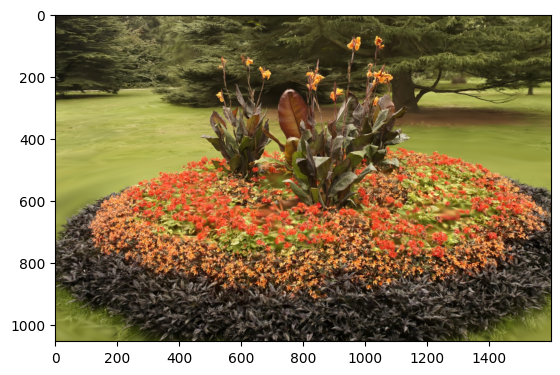

-226583.08


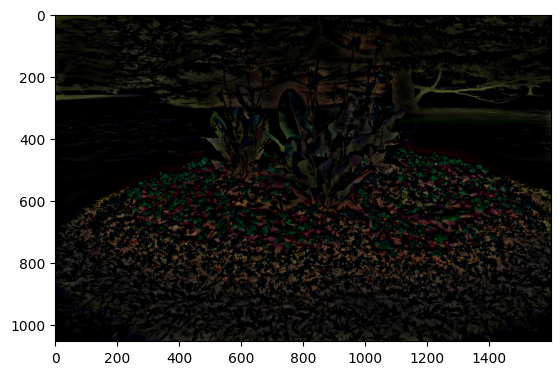

In [139]:
plt.imshow(render_pkg["render"].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

ifft_tensor_2 = ifft_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
ifft_tensor_2[ifft_tensor_2 > 0] = 0

print(ifft_tensor_2.sum())
plt.imshow(-ifft_tensor_2)
plt.show()

In [120]:
frequency_map_ = frequency_map.cpu()
top_k_percent_mask_ = top_k_percent_mask.cpu()

In [121]:
(frequency_map_ != frequency_map.cpu()).sum(), (top_k_percent_mask_ != top_k_percent_mask.cpu()).sum()

(tensor(0), tensor(0))

In [122]:
selected_pts_mask = high_freq_gaussian_mask
gaussians_new = GaussianModel(params_.sh_degree)

gaussians_new._xyz = gaussians._xyz[selected_pts_mask]
gaussians_new._scaling = gaussians._scaling[selected_pts_mask]
gaussians_new._features_dc = gaussians._features_dc[selected_pts_mask]
gaussians_new._features_rest = gaussians._features_rest[selected_pts_mask]
gaussians_new._rotation = gaussians._rotation[selected_pts_mask]
gaussians_new._opacity = gaussians._opacity[selected_pts_mask]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


start from address : 0
chunk address : 72396, geom.depths address : 0, takes up memory : 72396
chunk address : 126745, geom.clamped address : 72448, takes up memory : 54297
chunk address : 199244, geom.internal_radii address : 126848, takes up memory : 72396
chunk address : 344088, geom.means2D address : 199296, takes up memory : 144792
chunk address : 778568, geom.cov3D address : 344192, takes up memory : 434376
chunk address : 1068208, geom.conic_opacity address : 778624, takes up memory : 289584
chunk address : 1285476, geom.rgb address : 1068288, takes up memory : 217188
chunk address : 1357900, geom.tiles_touched address : 1285504, takes up memory : 72396
chunk address : 1358719, geom.scanning_space address : 1357952, takes up memory : 767
chunk address : 1431116, geom.point_offsets address : 1358720, takes up memory : 72396
chunk size : 1431244
chunkptr addr : 533326848
start from address : 533326848
chunk address : 533399244, geom.depths address : 533326848, takes up memory : 72

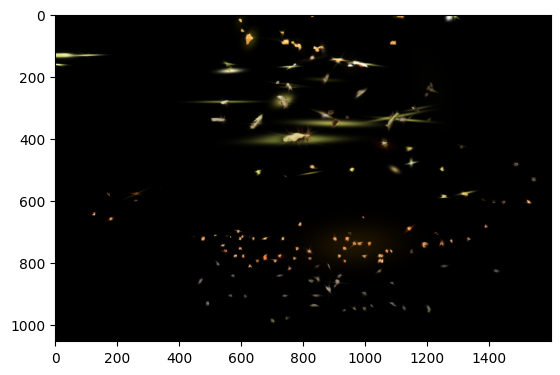

In [123]:
render_pkg2 = render(
    cam, gaussians_new, pipe_params_, background
)

image_rendered_torch2 = render_pkg2["render"]

plt.imshow(render_pkg2['render'].detach().cpu().permute(1,2,0).numpy())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


start from address : 0
chunk address : 72396, geom.depths address : 0, takes up memory : 72396
chunk address : 126745, geom.clamped address : 72448, takes up memory : 54297
chunk address : 199244, geom.internal_radii address : 126848, takes up memory : 72396
chunk address : 344088, geom.means2D address : 199296, takes up memory : 144792
chunk address : 778568, geom.cov3D address : 344192, takes up memory : 434376
chunk address : 1068208, geom.conic_opacity address : 778624, takes up memory : 289584
chunk address : 1285476, geom.rgb address : 1068288, takes up memory : 217188
chunk address : 1357900, geom.tiles_touched address : 1285504, takes up memory : 72396
chunk address : 1358719, geom.scanning_space address : 1357952, takes up memory : 767
chunk address : 1431116, geom.point_offsets address : 1358720, takes up memory : 72396
chunk size : 1431244
chunkptr addr : 6919168
start from address : 6919168
chunk address : 6991564, geom.depths address : 6919168, takes up memory : 72396
chun

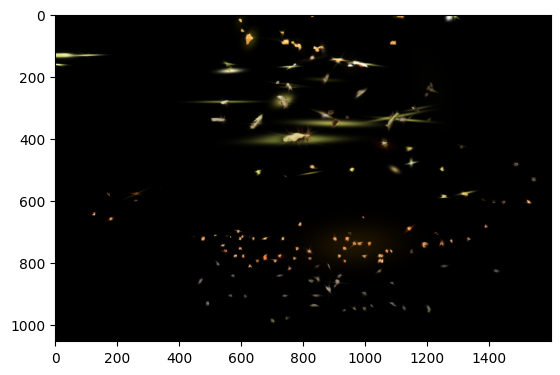

In [125]:
selected_pts_mask = high_freq_gaussian_mask
gaussians_new = GaussianModel(params_.sh_degree)

gaussians_new._xyz = gaussians._xyz[selected_pts_mask]
gaussians_new._scaling = gaussians._scaling[selected_pts_mask]
gaussians_new._features_dc = gaussians._features_dc[selected_pts_mask]
gaussians_new._features_rest = gaussians._features_rest[selected_pts_mask]
gaussians_new._rotation = gaussians._rotation[selected_pts_mask]
gaussians_new._opacity = gaussians._opacity[selected_pts_mask]
render_pkg2 = render(
    cam, gaussians_new, pipe_params_, background
)

image_rendered_torch2 = render_pkg2["render"]

plt.imshow(render_pkg2['render'].detach().cpu().permute(1,2,0).numpy())


In [28]:
from tqdm import tqdm

In [140]:
patch_size = (8, 8)
high_freq_proportion = 0.00005

bg_color = [1,1,1] if params_.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

per_cam_data_dict = {}

for cam in tqdm(scene.getTrainCameras()) :
    render_pkg = render(
        cam, gaussians, pipe_params_, background
    )
    image_rendered_torch = render_pkg["render"]

    f = torch.fft.fft2(image_rendered_torch, norm='ortho')
    fshift = torch.fft.fftshift(f).to(device)

    y, x = torch.meshgrid(
                    torch.linspace(-1, 1, image_rendered_torch.shape[1], device=device),
                    torch.linspace(-1, 1, image_rendered_torch.shape[2], device=device),
                )
    cov_mat = torch.tensor(
        [[0.0005, 0],
        [0, 0.0005]],
        dtype=torch.float32,device=device
    )

    gs_high_filter = 1 - torch.exp(
        -torch.sum(
            torch.mul(
                torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
                torch.linalg.inv(cov_mat) @ torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
            ),
            axis=0
        ).view(image_rendered_torch.shape[1], image_rendered_torch.shape[2])
    )

    high_freq_region = fshift * gs_high_filter

    ifft_tensor = torch.fft.ifft2(torch.fft.ifftshift(high_freq_region), norm='ortho').to(torch.float32)

    frequency_map = get_frequency_map(torch.abs(ifft_tensor), patch_size)
    top_k_percent_mask = get_top_k_percent_mask(frequency_map, high_freq_proportion)

    high_freq_patch_ridx_list, high_freq_patch_cidx_list = np.where(top_k_percent_mask.cpu().numpy())
    patch_rcw_list = [[high_freq_patch_ridx_list[0], high_freq_patch_cidx_list[0], 1]]
    for ridx, cidx in zip(high_freq_patch_ridx_list, high_freq_patch_cidx_list):
        b = patch_rcw_list[-1][0]
        r = patch_rcw_list[-1][1] + patch_rcw_list[-1][2]
        if ridx == b and cidx == r:
            patch_rcw_list[-1][2] += 1
        else:
            patch_rcw_list.append([ridx, cidx, 1])
    high_freq_gaussian_mask = find_guassian_within_patches(
        patch_size, patch_rcw_list, render_pkg["means2D"], None
    )
            
    per_cam_data_dict[cam.image_name] = {
        "high_freq_gaussian_mask" : high_freq_gaussian_mask
    }
    

  2%|▏         | 3/173 [00:00<00:06, 27.52it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1442840576
start from address : -1442840576
chunk a

  6%|▋         | 11/173 [00:00<00:05, 32.21it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 11%|█         | 19/173 [00:00<00:04, 34.57it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 16%|█▌        | 27/173 [00:00<00:04, 36.40it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 23%|██▎       | 39/173 [00:01<00:03, 38.22it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 25%|██▍       | 43/173 [00:01<00:03, 37.71it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 29%|██▉       | 51/173 [00:01<00:03, 31.78it/s]

chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1442840576
start from address : -1442840576
chunk address : -1428294784, geom.depths address : -1442840576, takes up memory : 14545792
chunk address : -1417385440, geom.clamped address : -1428294784, takes up memory : 10909344
chunk addre

 32%|███▏      | 55/173 [00:01<00:03, 32.18it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1442840576
start from address : -1442840576
chunk a

 36%|███▋      | 63/173 [00:01<00:03, 32.09it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 39%|███▊      | 67/173 [00:02<00:04, 23.24it/s]

chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk address : -1797393536, geom.depths address : -1811939328, takes up memory : 14545792
chunk address : -1786484192, geom.clamped address : -1797393536, takes up memory : 10909344
chunk address : -1771938304, geom.internal_radii address : -1786484096, takes up memory : 14545792
chunk address : -1742846720, geom.means2D address : -1771938304, takes up memory : 29091584
chunk address : -1655571968, geom.cov3D address : -1742846720, takes up memory : 872

 40%|████      | 70/173 [00:02<00:04, 21.13it/s]

chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk address : -1797393536, geom.depths address : -1811939328, takes up memory : 14545792
chunk address : -

 44%|████▍     | 76/173 [00:02<00:04, 23.66it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 46%|████▌     | 80/173 [00:02<00:03, 26.24it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 51%|█████▏    | 89/173 [00:02<00:02, 32.09it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 56%|█████▌    | 97/173 [00:03<00:02, 34.67it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 61%|██████    | 105/173 [00:03<00:02, 30.48it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 65%|██████▌   | 113/173 [00:03<00:01, 31.64it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

 70%|██████▉   | 121/173 [00:03<00:01, 33.87it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : 127772672
start from address : 127772672
chunk addre

 75%|███████▍  | 129/173 [00:04<00:01, 35.92it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : 127772672
start from address : 127772672
chunk addre

 79%|███████▉  | 137/173 [00:04<00:00, 36.74it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : 127772672
start from address : 127772672
chunk addre

 84%|████████▍ | 145/173 [00:04<00:00, 37.60it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1442840576
start from address : -1442840576
chunk a

 88%|████████▊ | 153/173 [00:04<00:00, 37.24it/s]

chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1442840576
start from address : -1442840576
chunk address : -1428294784, geom.depths address : -1442840576, takes up memory : 14545792
chunk address : -1417385440, geom.clamped address : -1428294784, takes up memory : 10909344
chunk addre

 93%|█████████▎| 161/173 [00:04<00:00, 37.44it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : 127772672
start from address : 127772672
chunk addre

 98%|█████████▊| 170/173 [00:05<00:00, 38.43it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : 127772672
start from address : 127772672
chunk addre

100%|██████████| 173/173 [00:05<00:00, 33.16it/s]

start from address : 0
chunk address : 14545792, geom.depths address : 0, takes up memory : 14545792
chunk address : 25455136, geom.clamped address : 14545792, takes up memory : 10909344
chunk address : 40001024, geom.internal_radii address : 25455232, takes up memory : 14545792
chunk address : 69092608, geom.means2D address : 40001024, takes up memory : 29091584
chunk address : 156367360, geom.cov3D address : 69092608, takes up memory : 87274752
chunk address : 214550528, geom.conic_opacity address : 156367360, takes up memory : 58183168
chunk address : 258187904, geom.rgb address : 214550528, takes up memory : 43637376
chunk address : 272733696, geom.tiles_touched address : 258187904, takes up memory : 14545792
chunk address : 272749567, geom.scanning_space address : 272733696, takes up memory : 15871
chunk address : 287295360, geom.point_offsets address : 272749568, takes up memory : 14545792
chunk size : 287295488
chunkptr addr : -1811939328
start from address : -1811939328
chunk a

In [141]:
masks = [val['high_freq_gaussian_mask'] for val in per_cam_data_dict.values()]
stacked_masks = torch.stack(masks)

combined_gaussian_mask = torch.any(stacked_masks, dim=0)

combined_gaussian_mask.sum(), combined_gaussian_mask.shape

(tensor(28420), torch.Size([3636448]))

In [ ]:
1796658

In [128]:
combined_gaussian_mask = torch.any(
    torch.vstack(list(map(
        lambda val : val["high_freq_gaussian_mask"],
        per_cam_data_dict.values()
    ))),
    dim=0
)
combined_gaussian_mask.sum(), combined_gaussian_mask.shape

(tensor(3444106), torch.Size([3636448]))

In [37]:
torch.vstack(list(map(
    lambda val : val["high_freq_gaussian_mask"],
    per_cam_data_dict.values()
))).sum(dim=1)

tensor([  36044,   83162,   26160,   31425, 1709864,   45448, 1179276, 2779905,
          33245,   67873,   39116,   24021, 1257353,  100251, 1174635,   43429,
          24607, 3553236, 1677910,   45399,   39699, 1676032,   65555,   43594,
          34010,   23691,   42446, 1142015,   23758,   33574,   27644,   63906,
          19226,   72897,   33200, 1122980,   60431,   29585,   19462,   51722,
          73707,   37269,   10782,   60761, 1696932,   33369,   28083,   61126,
          45894, 1922955,   38829,   31617,   56130,   53292, 2726096,   71571,
          57112,  783097, 1256769,   65048,   59729,   53338,   41648, 2004139,
          17815,   40723,   50069,   61073,   44065,   95645,   27297, 1612234,
          39187,   10347, 1464439,   49672,   38699, 1520854,   27446,   58148,
        1349273,   51760,   67108,   68770,   32578,   12297,   56814,   44619,
          17838,   49003,   31606, 1613343,   38174, 1156898,   55030,   65770,
          72270,   55323, 3401107,   268

In [39]:
combined_gaussian_mask.shape, combined_gaussian_mask.sum()

(torch.Size([6131954]), tensor(0))

In [21]:
torch.vstack(list(map(
    lambda val : val["high_freq_gaussian_mask"],
    per_cam_data_dict.values()
)))

tensor([[False,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True, False],
        [ True,  True, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False]])

In [18]:
import torch

# Example tensor
t = torch.tensor([2, 5, 1, 6, 3, 1, 4])

mask = t > 3

# Extract indices where the condition is True
indices = mask.nonzero(as_tuple=False).squeeze()

# Apply the mask to get the filtered tensor
filtered_tensor = t[mask]

print("Original Tensor:", tensor)
print("Mask:", mask)
print("Filtered Tensor:", filtered_tensor)
print("Indices of Filtered Elements:", indices)


Original Tensor: tensor([2, 5, 1, 6, 3, 1, 4])
Mask: tensor([False,  True, False,  True, False, False,  True])
Filtered Tensor: tensor([5, 6, 4])
Indices of Filtered Elements: tensor([1, 3, 6])


tensor([[1],
        [3],
        [6]])

In [7]:
PIXEL_VAL_THRESH = 0.2
indices = torch.nonzero(mean_values > PIXEL_VAL_THRESH).to(device)
indices

tensor([[   0,    0],
        [   0,    1],
        [   0,    2],
        ...,
        [1062, 1578],
        [1062, 1579],
        [1062, 1580]], device='cuda:0')

In [21]:
from tqdm import tqdm

In [22]:
indices.shape

torch.Size([724514, 2])

In [44]:
indices.device, gs_mean.device

(device(type='cuda', index=0), device(type='cpu'))

In [23]:
render_pkg['means2D'].shape

torch.Size([9652766, 2])

In [46]:
gs_mean = render_pkg["means2D"].to(device)
gs_mean.min(dim=0)

gs_mean_ceil = torch.ceil(gs_mean).int().unsqueeze(1)
gs_mean_floor = torch.floor(gs_mean).int().unsqueeze(1)

matches_ceil = (gs_mean_ceil == indices.unsqueeze(0)).all(dim=2).any(dim=1)

RuntimeError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 47.54 GiB total capacity; 45.55 GiB already allocated; 33.88 MiB free; 46.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [48]:
gs_mean.shape, indices.shape

(torch.Size([9652766, 2]), torch.Size([724514, 2]))

In [41]:
import torch

# Example tensors A and B
A = torch.tensor([
    [2.3, 1.7], [4.1, 5.8], [0.2, 2.9], [10, 20]
])
B = torch.tensor([[3, 2], [4, 6], [0, 3]])

# Step 1: Calculate the ceiling of A
A_ceiled = torch.ceil(A).int()

# Step 2: Expand A_ceiled and B for comparison
# We expand A_ceiled to compare with each row of B
# A_ceiled_expanded: [A_ceiled.shape[0], 1, A_ceiled.shape[1]]
# B_expanded: [1, B.shape[0], B.shape[1]]
A_ceiled_expanded = A_ceiled.unsqueeze(1)
B_expanded = B.unsqueeze(0)

# Compare all pairs of rows
matches = (A_ceiled_expanded == B_expanded)

# Step 3: Reduce using all (to check if all elements in a row match) and any (to see if there is any matching row)
# The result is a [A_ceiled.shape[0], B.shape[0]] tensor, reduce it along the dimension of B to see if any match found
mask = matches.all(dim=2).any(dim=1)

print(matches.shape)

torch.Size([4, 3, 2])


In [39]:
matches.shape

torch.Size([3, 3, 2])

In [31]:
gs_means2D.max(dim=0)

torch.return_types.max(
values=tensor([6895.0996, 1701.3899], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([2164177, 1141819], device='cuda:0'))

In [32]:
gs_means2D.min(dim=0)

torch.return_types.min(
values=tensor([2.9251e-09, 5.8929e-09], device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor([2135462,  392963], device='cuda:0'))

In [25]:

gs_2D_coordinates = torch.zeros([0,2]).to(device)
for pixel_coordinate in tqdm(indices):
    gs_2D_coordinates = torch.cat([gs_2D_coordinates, gs_means2D[((torch.abs(gs_means2D[:,0] - pixel_coordinate[0]) <= 1) & 
                                                        (torch.abs(gs_means2D[:,1] - pixel_coordinate[1]) <= 1))]] , dim=0)


  1%|▏         | 9223/724514 [00:05<07:35, 1568.98it/s]


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 47.54 GiB total capacity; 45.56 GiB already allocated; 3.88 MiB free; 46.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
gs_2D_coordinates.shape

torch.Size([15023, 2])

In [16]:
gs_2D_coordinates

tensor([[4.1910e-01, 1.0502e+00],
        [5.6006e-01, 1.5624e+00],
        [4.1147e-01, 1.4146e+00],
        ...,
        [4.5900e+01, 6.3368e+02],
        [4.5989e+01, 6.3849e+02],
        [4.5989e+01, 6.3849e+02]], device='cuda:0', grad_fn=<CatBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


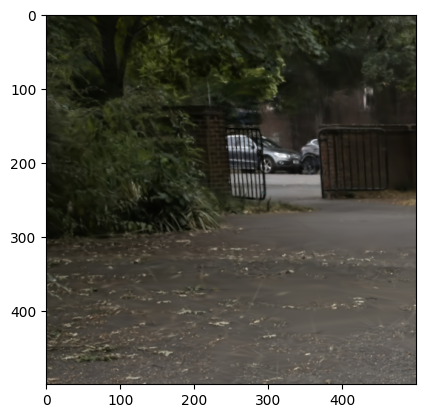

In [36]:
plt.imshow(render_pkg['render'].detach().permute(1,2,0).cpu().numpy()[:500,:500,:])
plt.show()

In [15]:
render_pkg['render'].shape

torch.Size([3, 1063, 1600])

In [29]:
render_pkg['means2D']

tensor([[857.5992, 271.1960],
        [854.7887, 215.9888],
        [899.0336, 438.7829],
        ...,
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000]], grad_fn=<_RasterizeGaussiansBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


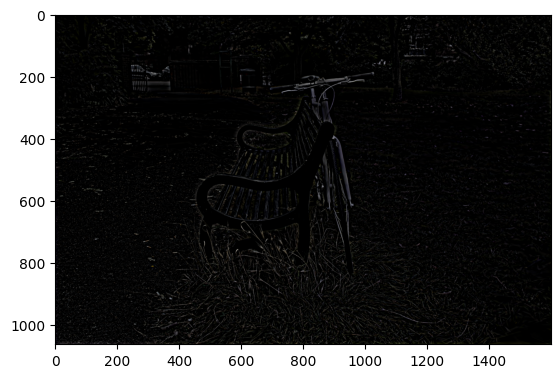

In [ ]:
cam = scene.getTrainCameras()[0]
bg_color = [1,1,1] if params_.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

#print(gaussians._xyz.shape)


render_pkg = render(
        cam, gaussians, pipe_params_, background
    )

image_rendered_torch = render_pkg["render"]

f = torch.fft.fft2(image_rendered_torch, norm='ortho')
fshift = torch.fft.fftshift(f)
device = "cuda"

y, x = torch.meshgrid(
                torch.linspace(-1, 1, image_rendered_torch.shape[1], device=device),
                torch.linspace(-1, 1, image_rendered_torch.shape[2], device=device),
            )

cov_mat = torch.tensor(
    [[0.005, 0],
    [0, 0.005]],
    dtype=torch.float32,device=device
)

gs_high_filter = 1 - torch.exp(
    -torch.sum(
        torch.mul(
            torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
            torch.linalg.inv(cov_mat) @ torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
        ),
        axis=0
    ).view(image_rendered_torch.shape[1], image_rendered_torch.shape[2])
)

high_freq_region = fshift * gs_high_filter


ifft_tensor = torch.fft.ifft2(torch.fft.ifftshift(high_freq_region), norm='ortho').to(torch.float32)



plt.imshow(ifft_tensor.detach().permute(1,2,0).cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1063, 1600])


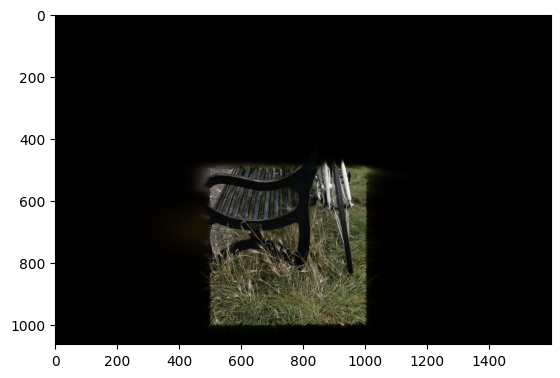

In [34]:

gaussians_2 = gaussians

# crop the rendered image (in this case, 500x500 patch)
selected_pts_mask = torch.where(torch.all((500 <= render_pkg['means2D']) & (render_pkg['means2D'] <= 1000), dim=1))[0]

gaussians_2._xyz = gaussians._xyz[selected_pts_mask]
gaussians_2._scaling = gaussians._scaling[selected_pts_mask]
gaussians_2._features_dc = gaussians._features_dc[selected_pts_mask]
gaussians_2._features_rest = gaussians._features_rest[selected_pts_mask]
gaussians_2._rotation = gaussians._rotation[selected_pts_mask]
gaussians_2._opacity = gaussians._opacity[selected_pts_mask]

render_pkg_2 = render(
        cam, gaussians_2, pipe_params_, background
    )

print(render_pkg_2['render'].shape)


plt.imshow(render_pkg_2['render'].detach().cpu().permute(1,2,0).numpy())
plt.show()